# Porod, Guinier and the Invariant
This scrit is supposed to do the following: \
Find 1D scattering curves in a directory \
Do the Porod fitting \
Subtract the q-Independent scattering and save the 1D curve \
\
Later Guinier fit can be done to calculate the invariant scattering via extrapolation

## Libraries

In [1]:
import pandas as pd
import os
import csv
import time

import numpy as np
import math
from scipy import optimize
import scipy.integrate as integrate
import scipy.constants as con
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap

## Job Parameters

In [137]:
# give the metadada directory
data_dir = 'C:\\Users\\eikeg\\Documents\\Science\\Xe_Physisorption\\All_I0'

# give the target file tyle:
target_file_type = '.dat'

porodFitting = True
guinierFitting = True
plotFitResults = True
plot_MixedGuinierPorod = True
plot_Kratky = True

# Fitting limits
# for high q regime - using porod like fitting
q_pe_min = 1.0 # Porod Fitting Range
q_pe_max = 1.8 # Porod fitting Range
q_pe_skipPoints = 30 # points to skip at the end indipendent from the actual q-range

# for high q regime - using Guinier like fitting
q_gu_min = 0.16 # Porod Fitting Range
q_gu_max = 0.25 # Porod fitting Range
q_gu_skipPoints = 0 # points to skip at the beginning indipendent from the actual q-range

# extrapolation to low and high q-values
q_extra_low = 0.01
q_extra_high = 20

# Porod Fit Funktions
c0_start = 0.03
c1_start = 0.000001
c4_start = 0.2
a_min = 3.8 # minimal expected exponent
a_max = 4.8 # maximal expected exponent
def porod_ext(x, c0, c1, c4, a):
    return c0 + c1 * x + c4 * x**(-a)
def porod_ext_q2(x, c0, c1, c4, a):
    return (c0 + c1 * x + c4 * x**(-a)) *x**2

# Guinier Fit Funktions
i0_start = 5000
rG_start = 3
def guinier(x, i0, rG):
    return i0 * np.exp(- rG**2 *x**(2/3))
def guinier_q2(x, i0, rG):
    return (i0 * np.exp(- rG**2 *x**(2/3))) *x**2

## Job
### Search the directory

In [138]:
# scan the directory
fileList = list()
for entry in os.scandir(data_dir):
    if entry.path.endswith(target_file_type) and entry.is_file():
        fileList.append(entry.path)

fileIterator = iter(fileList)
dF=pd.DataFrame()
for element in fileIterator: 
    dF = dF.append({'FileName':element.split(os.sep)[-1]},ignore_index=True)

C:\Users\eikeg\Documents\Science\Xe_Physisorption\All_I0\Step0_4753_4774_4780_I0.dat
Porod Optimization range used is: 1.00486012  to  1.81486012  nm-1 between Index  30  and  57
Guinier Optimization range used is: 0.16486012  to  0.25486012  nm-1 between Index  30  and  57
Low-q: 1.4526817755934076 Acquired-q: 29.42756246176016 High-q: 0.6184063988446719 Sum: 31.498650636198242
Low-q: 4.6118857355876255 % Acquired-q: 93.42483524656771 % High-q: 1.9632790178446546 %

C:\Users\eikeg\Documents\Science\Xe_Physisorption\All_I0\Step10_4753_4774_4780_I0.dat
Porod Optimization range used is: 1.00486012  to  1.81486012  nm-1 between Index  30  and  57
Guinier Optimization range used is: 0.16486012  to  0.25486012  nm-1 between Index  30  and  57
Low-q: 1.8511088947420289 Acquired-q: 27.366614794287642 High-q: 0.1501531636357164 Sum: 29.36787685266539
Low-q: 6.303175759108457 % Acquired-q: 93.1855405536539 % High-q: 0.5112836872376381 %

C:\Users\eikeg\Documents\Science\Xe_Physisorption\All_I0\

C:\Users\eikeg\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\eikeg\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



C:\Users\eikeg\Documents\Science\Xe_Physisorption\All_I0\Step4_4680_4753_4774_I0.dat
Porod Optimization range used is: 1.00486012  to  1.81486012  nm-1 between Index  30  and  57
Guinier Optimization range used is: 0.16486012  to  0.25486012  nm-1 between Index  30  and  57
Low-q: 0.4652368228534439 Acquired-q: 4.043438722220713 High-q: 6.667452113593692e-19 Sum: 4.508675545074157
Low-q: 10.318702647870216 % Acquired-q: 89.68129735212979 % High-q: 1.4788050386278193e-17 %

C:\Users\eikeg\Documents\Science\Xe_Physisorption\All_I0\Step5R1_4436_4680_4753_I0.dat
Porod Optimization range used is: 1.004  to  1.814  nm-1 between Index  30  and  57
Guinier Optimization range used is: 0.16399999999999998  to  0.254  nm-1 between Index  30  and  57
Low-q: 1.1502271200719814 Acquired-q: 19.572001431804328 High-q: 0.24912589269714971 Sum: 20.97135444457346
Low-q: 5.484753610511856 % Acquired-q: 93.32731218449636 % High-q: 1.1879342049917687 %

C:\Users\eikeg\Documents\Science\Xe_Physisorption\All

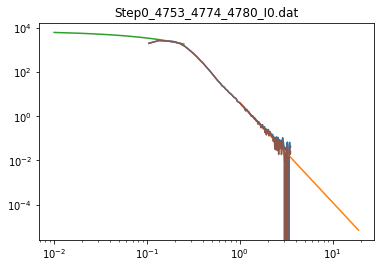

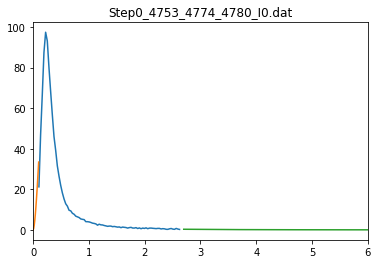

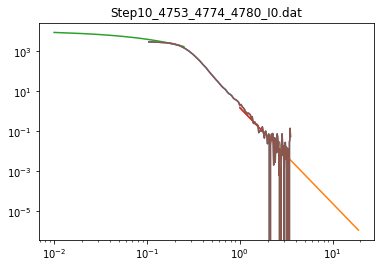

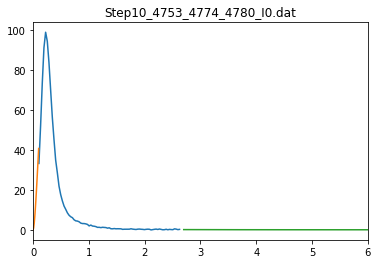

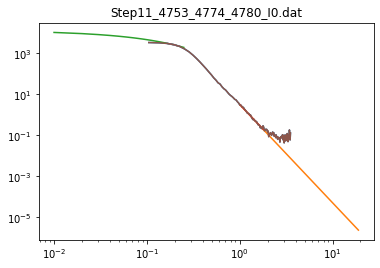

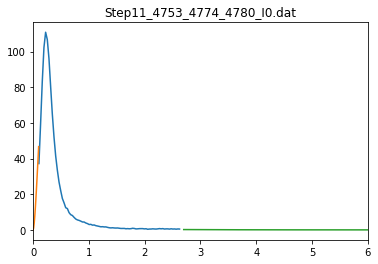

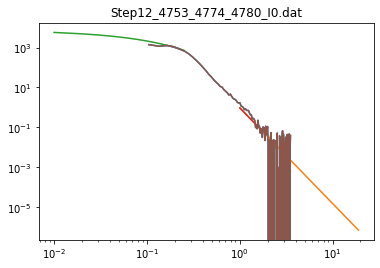

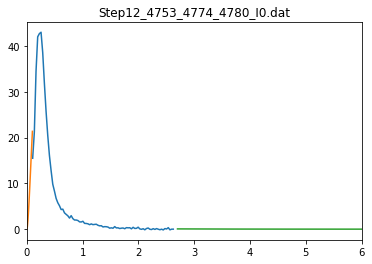

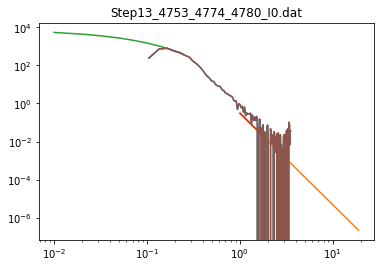

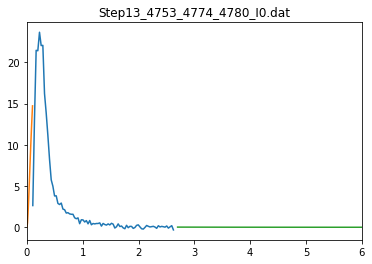

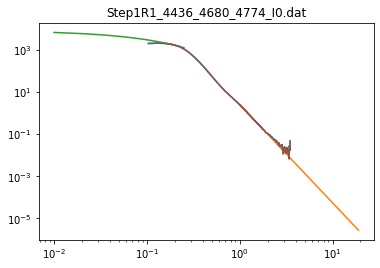

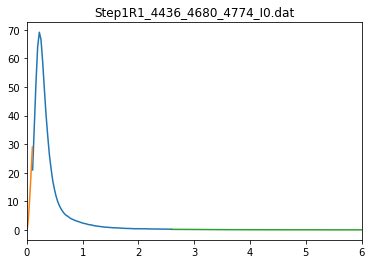

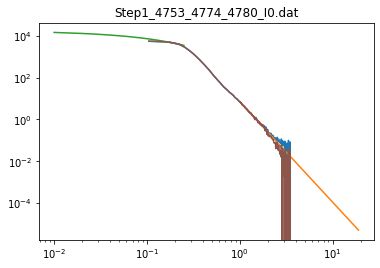

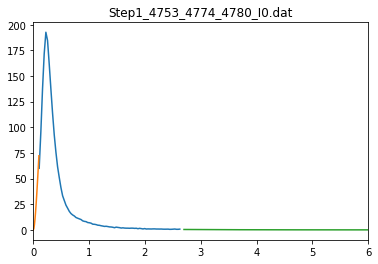

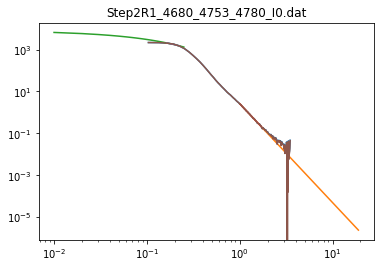

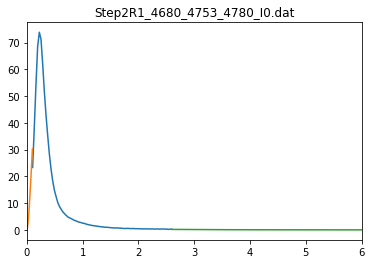

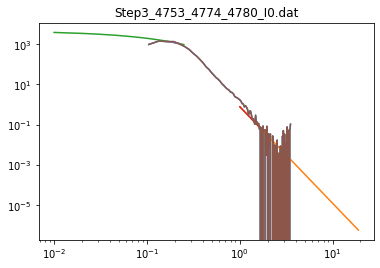

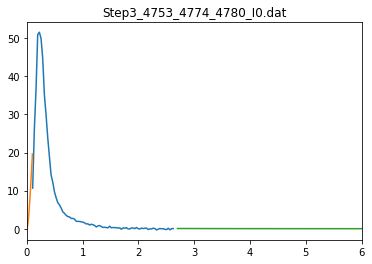

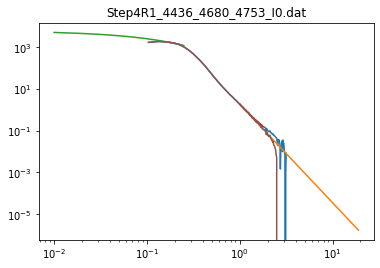

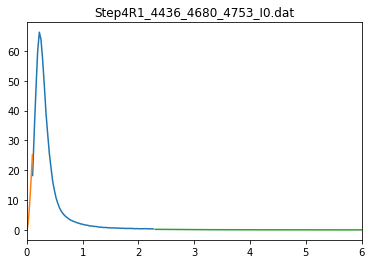

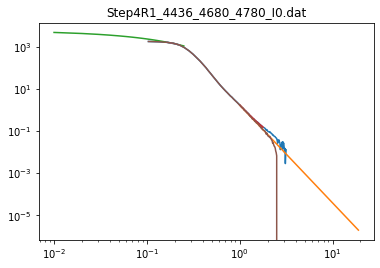

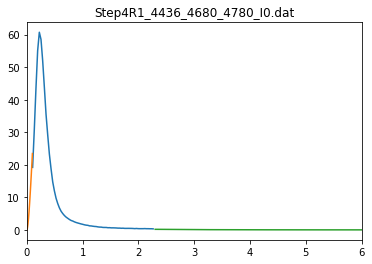

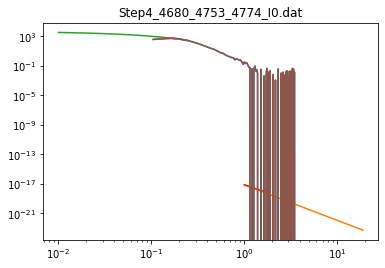

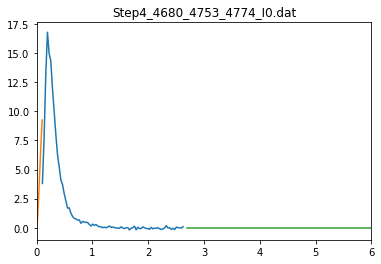

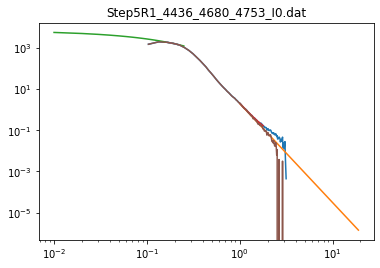

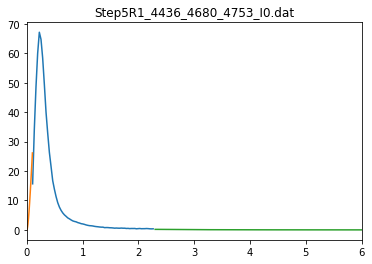

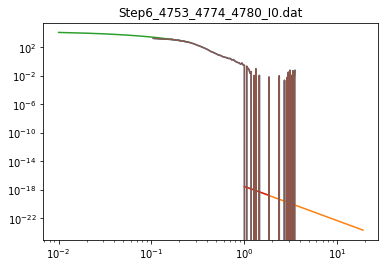

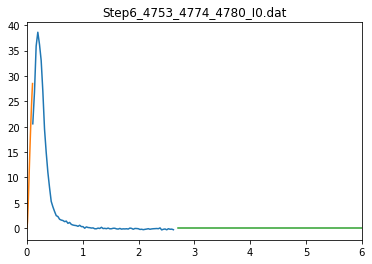

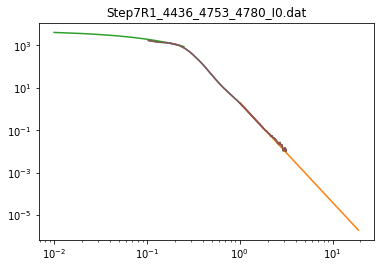

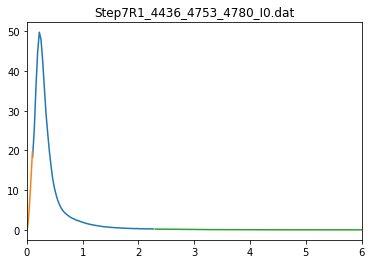

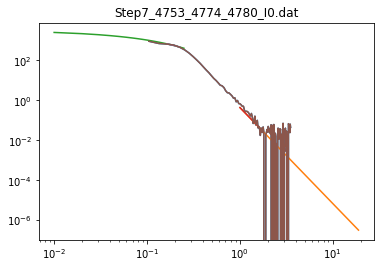

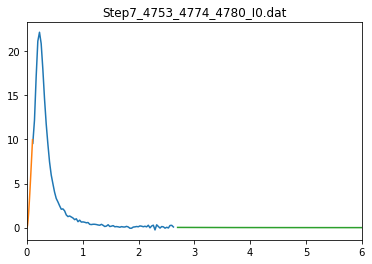

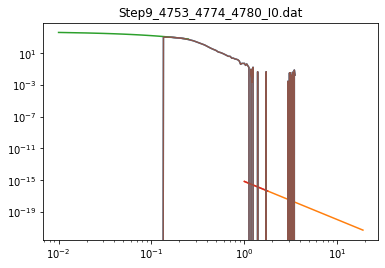

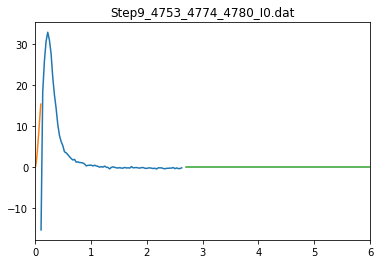

In [139]:
# make an path iterator from the found files
fileIterator = iter(fileList)
dF_pe=pd.DataFrame()
dF_gu=pd.DataFrame()
dF_inv=pd.DataFrame()

for element in fileIterator:
    q, I, e = np.genfromtxt(element,delimiter=',',unpack=True) # np.genfromtxt(element,skip_header=0,unpack=True)
    print(element)
    
    if porodFitting == True: 
        # Define Fitting range
        q_shop = q[:-q_pe_skipPoints]
        q_pe_IndexMin = min(range(q_shop.size), key=lambda i: abs(q_shop[i]-q_pe_min))
        q_pe_IndexMax = min(range(q_shop.size), key=lambda i: abs(q_shop[i]-q_pe_max))
        print('Porod Optimization range used is:',q[q_pe_IndexMin],' to ',q[q_pe_IndexMax],' nm-1 between Index ',q_pe_IndexMin,' and ',q_pe_IndexMax)
        # Actual Fitting
        param_bounds_pe=([0,0,0,a_min],[10*c0_start,10*c1_start,100*c4_start,a_max])
        popt, pcov =optimize.curve_fit(porod_ext,q[q_pe_IndexMin:q_pe_IndexMax],I[q_pe_IndexMin:q_pe_IndexMax],bounds=param_bounds_pe,sigma=e[q_pe_IndexMin:q_pe_IndexMax])
        # Output Data
        dF_pe = dF_pe.append({'Porod_qMin':q[q_pe_IndexMin],'Porod_qMax':q[q_pe_IndexMax],'c0':popt[0],'c1':popt[1],'c4':popt[2],'a':popt[3]},ignore_index=True)
        #dF = dF.append(dF_pe)
        # Plotting the result
        if plotFitResults == True and guinierFitting == False:
            q_pe = q[q_pe_IndexMin:q_pe_IndexMax]
            I_pe = porod_ext(q_pe,popt[0], popt[1], popt[2], popt[3])
            fig, ax = plt.subplots()
            ax.plot(q, I)
            ax.plot(q_pe, I_pe)
            ax.plot(q,I-popt[0])
            plt.title(element.split(os.sep)[-1], fontdict=None, loc='center', pad=None)
            ax.loglog()
        else:
            pass
        I_out=I-popt[0]
        
    if guinierFitting == True:
        # Define Fitting range
        q_gu_shop = q[q_gu_skipPoints:]
        q_gu_IndexMin = min(range(q_gu_shop.size), key=lambda i: abs(q_gu_shop[i]-q_gu_min))
        q_gu_IndexMax = min(range(q_gu_shop.size), key=lambda i: abs(q_gu_shop[i]-q_gu_max))
        print('Guinier Optimization range used is:',q[q_gu_IndexMin],' to ',q[q_gu_IndexMax],' nm-1 between Index ',q_pe_IndexMin,' and ',q_pe_IndexMax)
        # Actual Fitting
        param_bounds_gu=([0.1*i0_start,0.5*rG_start],[10*i0_start,2*rG_start])
        popt_gu, pcov_gu =optimize.curve_fit(guinier,q[q_gu_IndexMin:q_gu_IndexMax],I[q_gu_IndexMin:q_gu_IndexMax],bounds=param_bounds_gu,sigma=e[q_gu_IndexMin:q_gu_IndexMax])
        # Output Data
        dF_gu = dF_gu.append({'Guinier_qMin':q[q_gu_IndexMin],'Guinier_qMax':q[q_gu_IndexMax],'i0':popt_gu[0],'rG':popt_gu[1],},ignore_index=True)
        # Plotting the result
        if plotFitResults == True and porodFitting == False:
            q_gu = q[q_gu_IndexMin:q_gu_IndexMax]
            I_gu = guinier(q_gu,popt_gu[0], popt_gu[1])
            fig, ax = plt.subplots()
            ax.plot(q, I)
            ax.plot(q_gu, I_gu)
            #ax.plot(q,I-popt[0])
            plt.title(element.split(os.sep)[-1], fontdict=None, loc='center', pad=None)
            ax.loglog()
        else:
            pass
    if plotFitResults == True and porodFitting == True and guinierFitting == True and plot_MixedGuinierPorod == True:
        q_pe = q[q_pe_IndexMin:q_pe_IndexMax]
        I_pe = porod_ext(q_pe,popt[0], popt[1], popt[2], popt[3])
        q_gu = q[q_gu_IndexMin:q_gu_IndexMax]
        I_gu = guinier(q_gu,popt_gu[0], popt_gu[1])
        q_pe_extra = np.arange(q[q_pe_IndexMin], q_extra_high, 1)
        q_gu_extra = np.arange(q_extra_low, q[q_gu_IndexMax], 0.01)
        
        fig, ax = plt.subplots()
        ax.plot(q, I)
        ax.plot(q_pe_extra, porod_ext(q_pe_extra,0, 0, popt[2], popt[3]))
        ax.plot(q_gu_extra, guinier(q_gu_extra,popt_gu[0], popt_gu[1]))
        ax.plot(q_pe, I_pe)
        ax.plot(q_gu, I_gu)
        
        #I_subtraced = porod_ext(q,popt[0], popt[1], 0, 0)
        ax.plot(q,I-porod_ext(q,popt[0], popt[1], 0, 0))
        plt.title(element.split(os.sep)[-1], fontdict=None, loc='center', pad=None)
        ax.loglog()
    else:
        pass
    
    if porodFitting == True and guinierFitting == True:
        # Data for Kratky Plot - Ky
        I_acq_Ky = I[q_gu_skipPoints:-q_pe_skipPoints]
        q_acq_Ky = q[q_gu_skipPoints:-q_pe_skipPoints]
        q_low_Ky = np.arange(0, q[q_gu_skipPoints], 0.01)
        I_low_Ky = guinier(q_low_Ky,popt_gu[0], popt_gu[1])
        q_high_Ky = np.arange(math.ceil(q[:-q_pe_skipPoints][-1]*10)/10, 100, 1)
        I_high_Ky = porod_ext(q_high_Ky,0, 0, popt[2], popt[3])
        # For the export
        q_export=np.concatenate((q_low_Ky, q_acq_Ky,q_high_Ky))
        I_export=np.concatenate((I_low_Ky, I_acq_Ky,I_high_Ky))
        Iq2_export=I_export*q_export**2
        
        # Integration of Invariant
        Iq2_acq = I_acq_Ky*q_acq_Ky**2
        int_acq = integrate.trapz(y=Iq2_acq ,x=q_acq_Ky, axis=- 1)     
        int_l, e_int_l = integrate.quad(guinier_q2, 0, q[q_gu_skipPoints], args=(popt_gu[0],popt_gu[1]))
        int_h, e_int_h = integrate.quad(porod_ext_q2, q[:-q_pe_skipPoints][-1], 100, args=(0, 0, popt[2], popt[3]))
        invariant = int_acq + int_l + int_h
        
        print('Low-q:',int_l,'Acquired-q:',int_acq,'High-q:',int_h,'Sum:',invariant)
        print('Low-q:',int_l/invariant*100,'% Acquired-q:',int_acq/invariant*100,'% High-q:',int_h/invariant*100,'%')
        
        dF_inv = dF_inv.append({'Invariant':invariant,'Inv_Measured':int_acq,'Inv_Extrapolated_LowQ':int_l,'Inv_Extrapolated_HighQ':int_h,},ignore_index=True)
        
        if plot_Kratky == True:
            fig, ax = plt.subplots()
            ax.plot(q_acq_Ky, I_acq_Ky*q_acq_Ky**2)
            ax.plot(q_low_Ky, I_low_Ky*q_low_Ky**2)
            ax.plot(q_high_Ky, I_high_Ky*q_high_Ky**2)

            plt.title(element.split(os.sep)[-1], fontdict=None, loc='center', pad=None)

            plt.xlim(xmax = 6, xmin = 0)
        else:
            pass
        print('')
        
    
    # Save Numpy array to csv with header    
    save_file_name = element[:-4]+'_Invariant'+'.txt'
    file_header = str(element.split(os.sep)[-1])+'\tc0_Subtracted and Invariant c0=\t'+str(popt[0])+'\n'+'q\tI\tI*q^2\nnm-1\tcm-1\tcm-1 nm-2'
    np.savetxt(save_file_name, np.column_stack((q_export, I_export, Iq2_export)), delimiter='\t', header=file_header)

# Save Pandas Frame to csv with header    
outputFrame = pd.concat([dF,dF_pe,dF_gu,dF_inv],axis=1)
save_outPut_name = data_dir+os.sep+data_dir.split(os.sep)[-1]+'Invariant_logg'+'.txt'
outputFrame.to_csv(save_outPut_name, sep='\t')

In [140]:
outputFrame

,FileName,Porod_qMax,Porod_qMin,a,c0,c1,c4,Guinier_qMax,Guinier_qMin,i0,rG,Inv_Extrapolated_HighQ,Inv_Extrapolated_LowQ,Inv_Measured,Invariant
0,Step0_4753_4774_4780_I0.dat,1.81486,1.00486,4.490195,1.722614e-02,3.127200e-07,3.899290e+00,0.25486,0.16486,7023.579880,1.855855,6.184064e-01,1.452682,29.427562,31.498651
1,Step10_4753_4774_4780_I0.dat,1.81486,1.00486,4.800000,2.265419e-17,8.644085e-22,1.537511e+00,0.25486,0.16486,11073.499219,2.155715,1.501532e-01,1.851109,27.366615,29.367877
2,Step11_4753_4774_4780_I0.dat,1.81486,1.00486,4.800000,4.523008e-18,1.000000e-05,3.181479e+00,0.25486,0.16486,13163.991452,2.192976,3.107029e-01,2.138666,32.513912,34.963282
3,Step12_4753_4774_4780_I0.dat,1.81486,1.00486,4.800000,7.157188e-15,2.303109e-19,9.604387e-01,0.25486,0.16486,7563.291051,2.421815,9.379635e-02,1.021143,12.847750,13.962689
4,Step13_4753_4774_4780_I0.dat,1.81486,1.00486,4.800000,2.164296e-12,5.481362e-17,3.156492e-01,0.25486,0.16486,7561.538727,2.755340,3.082627e-02,0.756889,6.884273,7.671988
5,Step1R1_4436_4680_4774_I0.dat,1.81400,1.00400,4.651820,3.824424e-05,5.486121e-16,2.454735e+00,0.25400,0.16400,8066.131301,2.178675,3.070397e-01,1.298544,20.588849,22.194433
6,Step1_4753_4774_4780_I0.dat,1.81486,1.00486,4.800000,5.518968e-02,1.000000e-05,6.853562e+00,0.25486,0.16486,17385.767640,2.018888,6.693181e-01,3.214733,57.219193,61.103244
7,Step2R1_4680_4753_4780_I0.dat,1.81400,1.00400,4.726349,2.202094e-03,9.999971e-06,2.574901e+00,0.25400,0.16400,8119.624835,2.139640,2.871977e-01,1.346346,21.847203,23.480747
8,Step3_4753_4774_4780_I0.dat,1.81486,1.00486,4.800000,1.282821e-14,3.978343e-19,7.922018e-01,0.25486,0.16486,4612.744011,1.992328,7.736635e-02,0.869163,14.566150,15.512679
9,Step4R1_4436_4680_4753_I0.dat,1.81400,1.00400,4.713340,3.821081e-02,1.478833e-15,1.847326e+00,0.25400,0.16400,6097.933639,2.026211,2.654706e-01,1.098636,19.143428,20.507535


In [141]:
element

'C:\\Users\\eikeg\\Documents\\Science\\Xe_Physisorption\\All_I0\\Step9_4753_4774_4780_I0.dat'